### Цели, заметки
####  (workload)
0. Refactoring, commenting
1. adapt plotting for multi-year
2. Statistical data by day: mean, variance, 
#### (marketing)


In [1]:
print('imports, options')
import pandas as pd
import datetime as dt
import calendar as cal
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# pd.set_option('display.max_colwidth',20) #change this to increse width cutoff limit
plt.rcParams['figure.figsize'] = [20, 10]
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

imports, options


In [2]:
print('Load file')
parser = lambda date: dt.datetime.strptime(date, '%d.%m.%y')
by_date = pd.read_excel('by_date.xls',skiprows=[0,1,2,3,4,5,6],header = 0,parse_dates=[0],date_parser=parser)
by_date = by_date.drop(columns = ['Unnamed: 2'])
by_date = by_date.rename(columns={'Документы реализации':'date','Поступление':'In','Unnamed: 1':'Name',
                                  'Реализация':'Out','Прибыль':'Prof %','Unnamed: 6':'Profit'})
by_date = by_date.drop([0,620])

by_date.head()

Load file


,date,Name,In,Out,Prof %,Profit
1,2018-06-01,Отчет ККМ № 0000000144 от 01.06.18 (касса фр),25463,41541.5,63.14,16078.5
2,2018-06-02,Списание ТМЦ № 0000000022 от 02.06.18 (),900,,-100,-900
3,2018-06-02,Отчет ККМ № 0000000145 от 02.06.18 (касса фр),20320.2,32801,61.42,12480.8
4,2018-06-03,Продажи по принятой выручке (ЕНВД) № 000000002...,130,250,92.31,120
5,2018-06-03,Отчет ККМ № 0000000146 от 03.06.18 (касса фр),16528.6,28382,71.71,11853.4


In [3]:
print('Functions')
def prt_summary(df,colName = 'Profit'):
    '''Prints statistical data'''
    print('statistical summary by {}'.format(colName))
    print(
        'mean: {0:.{1}f} '.format(df[colName].mean(),2),
        'std:  {0:.{1}f} '.format(df[colName].std(),2),
#         'Max:  {0:.{1}f} '.format(df[colName].max(),2),
#         'Min:  {0:.{1}f} '.format(df[colName].min(),2),
        sep='\n'

         )
    
    print(
        'max: {}'.format(df[df[colName]==df[colName].max()]),
        'min: {}'.format(df[df[colName]==df[colName].min()]),
        sep = '\n'
    )
    

prt_summary(by_date)

Functions
statistical summary by Profit
mean: 7047.49 
std:  6828.07 
max:           date                                               Name     In    Out Prof % Profit
529 2019-05-14  Реализация (купля-продажа) № 0000000036 от 14....  60260  96600  60.31  36340
min:           date                                      Name       In Out Prof %   Profit
530 2019-05-15  Списание ТМЦ № 0000000020 от 15.05.19 ()  7451.26       -100 -7451.26


In [4]:
print('Remove non-relevant docs: buyer refunds, exchange,etc.') 
retailSales = by_date[by_date['Name'].str.contains('Отчет ККМ')]

Remove non-relevant docs: buyer refunds, exchange,etc.


Visualisations


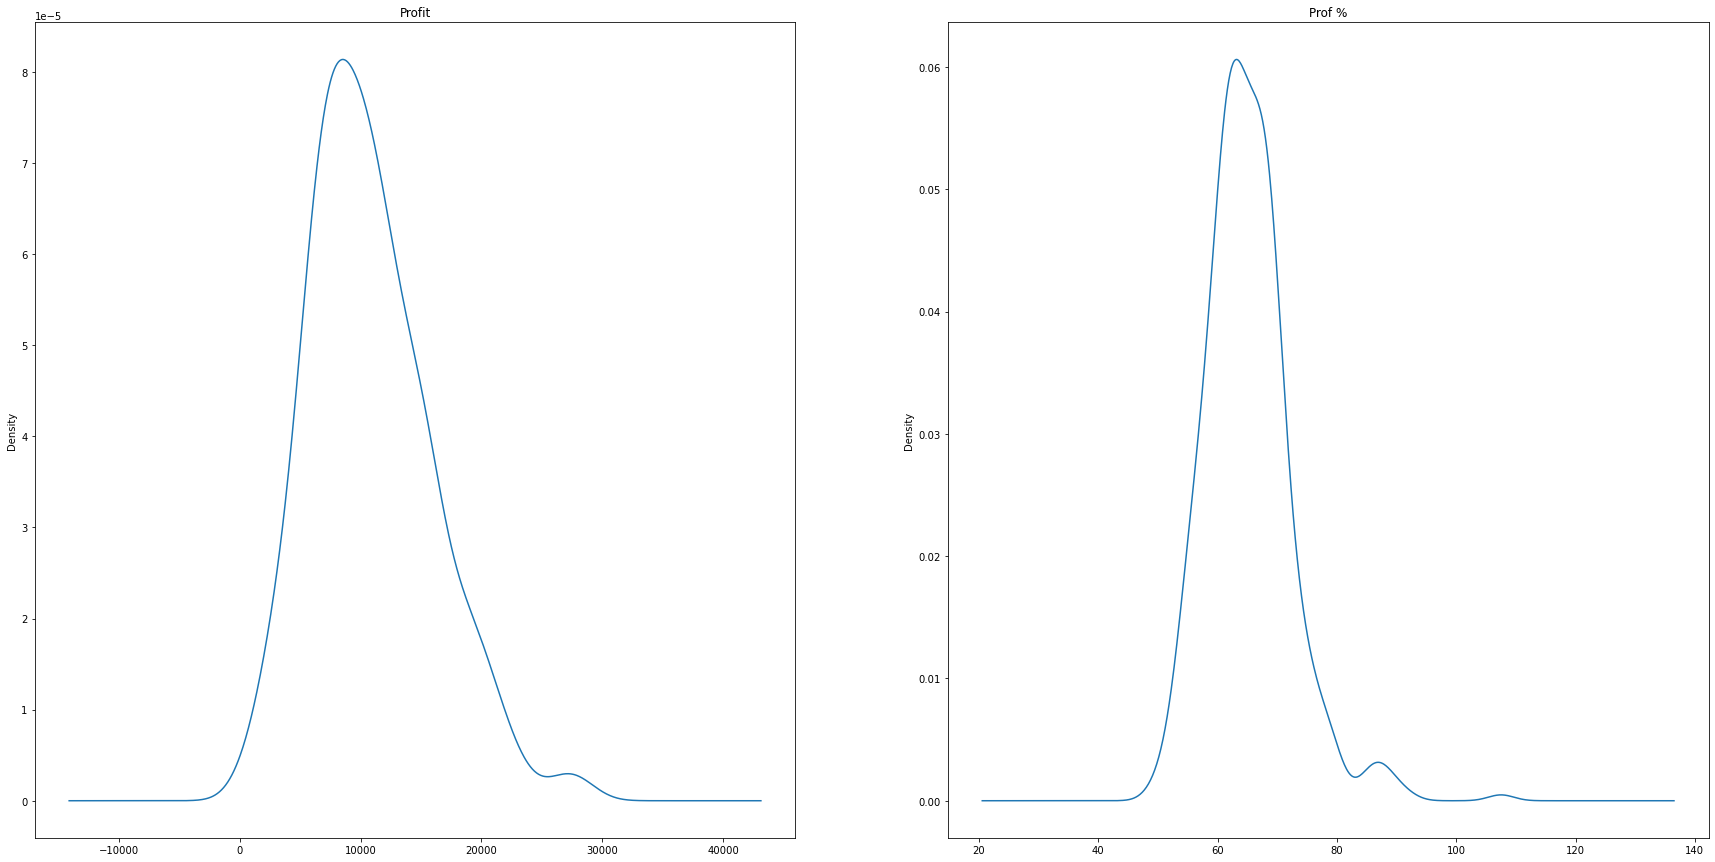

In [5]:
print('Visualisations')

colNames = ['Profit','Prof %']

fig, axes = plt.subplots(nrows=1,
                         ncols=len(colNames),
                         figsize=(30,15),
                         )

for n,colName in enumerate(colNames):
    '''!!!! NBINS!!!'''
#     nBins = int(retailSales[colName].max()-retailSales[colName].min())
#     nBins = 28
#     retailSales[colName].hist(bins=nBins,ax=axes[n])
    retailSales[colName].plot.kde(ax=axes[n],title=str(colName))

### Daily shop's turnover(Day:Month):

In [6]:
'''Set up dataframe'''
df = retailSales.copy()
prt_summary(df)

statistical summary by Profit
mean: 10832.58 
std:  5058.35 
max:          date                                           Name     In    Out Prof % Profit
32 2018-06-21  Отчет ККМ № 0000000163 от 21.06.18 (касса фр)  41481  70299  69.47  28818
min:          date                                           Name      In  Out  Prof %  Profit
38 2018-06-24  Отчет ККМ № 0000000167 от 24.06.18 (касса фр)  184.08  382  107.52  197.92


plot and stats by weekday
 Mon: mean=9230.0,std=3777.0 
 Tue: mean=10910.0,std=4667.0 
 Wed: mean=10367.0,std=4487.0 
 Thu: mean=11577.0,std=5993.0 
 Fri: mean=12130.0,std=5086.0 
 Sat: mean=13271.0,std=4982.0 
 Sun: mean=8351.0,std=4596.0 



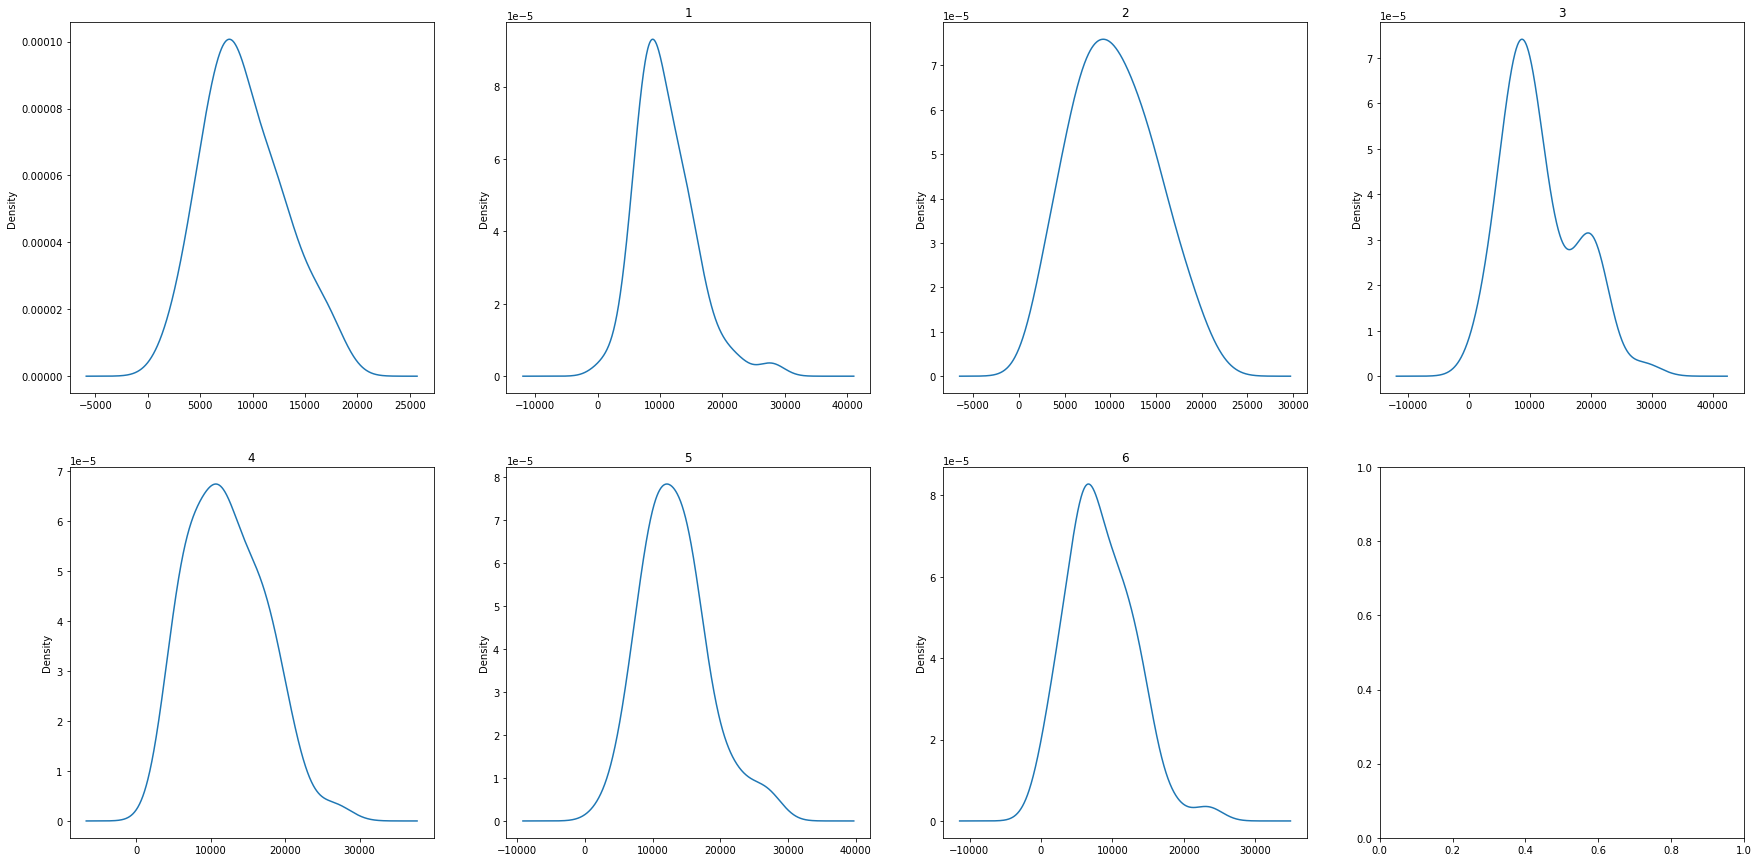

In [7]:
print('plot and stats by weekday')
colName = 'Profit'
df['weekday'] = df['date'].dt.dayofweek
line ='' #padding
for i in range(7):
    
    line+=' {}: mean={},std={} \n'.format(cal.day_abbr[i],
                                          round(df[df['weekday']==i][colName].mean()),
                                          round(df[df['weekday']==i][colName].std()),
                                         )
    
print(line)

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         figsize=(30,15),
                         )


for i in range(7):
    row = i//4
    col = i
    if i>3:
        col=i-4
#     df[df['weekday']==i][colName].hist(bins= 57,ax = axes[row,col])
    df[df['weekday']==i][colName].plot.kde(ax = axes[row,col],title=(i))
    
#     df[df['weekday']==i].plot(x='Profit', title=i, kind='hist',ax = axes[row,col])

Heatmap by weekday


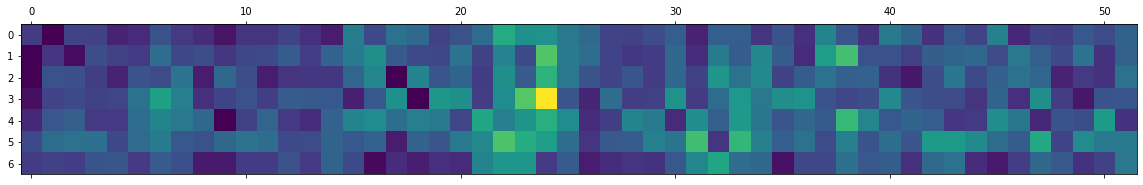

In [8]:
print('Heatmap by weekday')
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=0,strategy='mean')
plot = np.zeros((52,7))

colName = 'Profit'
# colName = 'Out'

for i,r in df.iterrows():
    plot[r[0].week-1,r[0].weekday()] += r[colName]#/df[colName].mean()
    
# impute missing values and outlier:
# plot = imp.fit_transform(plot)
# plot[68,1]= retailSales['Profit'].mean()/retailSales['Profit'].mean()

'''TICKS!!!'''
plt.figure() 
# plt.yticks(np.arange(7),labels=ticks)
plt.matshow(plot.T,fignum=0)
plt.show()

In [13]:
print('select 1 day:')
day = 3
week = 24

date = pd.Timestamp('2019-01-01') + pd.Timedelta(days = week*7+day)
if date>pd.Timestamp('2019-06-01'):
    date -= pd.Timedelta(days=365)

print(date,'\n', date.day_name(),'week:',date.week-1)

day = df.loc[lambda df: df['date']==date]
print('Z-SCORE', end=':       ')
for col in ['In', 'Out', 'Prof %', 'Profit']:
    zScore = (day.iloc[0][col] - df[col].mean())/df[col].std()
    print('{}:{}'.format(col,round(zScore,2)),end='      ')
    
    
day

select 1 day:
2018-06-21 00:00:00 
 Thursday week: 24
Z-SCORE:       In:2.99      Out:3.22      Prof %:0.61      Profit:3.56      

,date,Name,In,Out,Prof %,Profit,weekday
32,2018-06-21,Отчет ККМ № 0000000163 от 21.06.18 (касса фр),41481,70299,69.47,28818,3


In [10]:
break
print('Proft by month\day')
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import calendar

imp = SimpleImputer(missing_values=0,strategy='mean')
plot = np.zeros((12,31))


for i,r in df.iterrows():
    day = r['date'].day-1
    month = r['date'].month-1
    plot[month,day]+=r['Profit']/df['Profit'].mean()
    
# impute missing values and outlier:
# plot = imp.fit_transform(plot)
plot[4,15]= df['Profit'].mean()/df['Profit'].mean()



plt.figure()
# plt.yticks(np.arange(12), calendar.month_name[1:13], rotation=45)
plt.matshow(plot,fignum=0)
plt.show()

SyntaxError: 'break' outside loop (<ipython-input-10-2d1031f910a2>, line 4)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

ax.plot(plot[0,:])